# NPK Crop Recommendation Model Training

This notebook trains a machine learning model to recommend crops based on soil NPK levels.

## Features:
- N (Nitrogen): Amount of nitrogen in soil
- P (Phosphorus): Amount of phosphorus in soil  
- K (Potassium): Amount of potassium in soil

## Target:
- Crop: Recommended crop to plant

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

In [2]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


## 1. Create Sample Dataset

Since we don't have an existing dataset, let's create a realistic NPK crop recommendation dataset.

In [3]:
# Create a realistic NPK crop dataset
def create_npk_dataset(n_samples=2000):
    """
    Create a synthetic NPK crop recommendation dataset based on real-world crop requirements
    """
    np.random.seed(42)
    
    # Define crop requirements (N, P, K ranges and optimal values)
    crop_requirements = {
        'Rice': {'N': (80, 120), 'P': (40, 60), 'K': (40, 60)},
        'Wheat': {'N': (100, 140), 'P': (50, 70), 'K': (50, 70)},
        'Corn': {'N': (120, 180), 'P': (60, 90), 'K': (60, 100)},
        'Barley': {'N': (60, 100), 'P': (30, 50), 'K': (40, 60)},
        'Soybean': {'N': (40, 80), 'P': (40, 80), 'K': (80, 120)},
        'Cotton': {'N': (100, 150), 'P': (50, 80), 'K': (80, 120)},
        'Sugarcane': {'N': (150, 200), 'P': (60, 100), 'K': (100, 150)},
        'Tomato': {'N': (120, 160), 'P': (80, 120), 'K': (150, 200)},
        'Potato': {'N': (100, 140), 'P': (60, 100), 'K': (120, 180)},
        'Onion': {'N': (80, 120), 'P': (50, 80), 'K': (100, 140)}
    }
    
    data = []
    crops = list(crop_requirements.keys())
    
    for _ in range(n_samples):
        # Randomly select a crop
        crop = np.random.choice(crops)
        
        # Generate NPK values based on crop requirements with some noise
        n_min, n_max = crop_requirements[crop]['N']
        p_min, p_max = crop_requirements[crop]['P']
        k_min, k_max = crop_requirements[crop]['K']
        
        # Add some variability around optimal ranges
        n_val = np.random.normal((n_min + n_max) / 2, (n_max - n_min) / 6)
        p_val = np.random.normal((p_min + p_max) / 2, (p_max - p_min) / 6)
        k_val = np.random.normal((k_min + k_max) / 2, (k_max - k_min) / 6)
        
        # Ensure values are positive
        n_val = max(0, n_val)
        p_val = max(0, p_val)
        k_val = max(0, k_val)
        
        data.append([round(n_val, 2), round(p_val, 2), round(k_val, 2), crop])
    
    # Create DataFrame
    df = pd.DataFrame(data, columns=['N', 'P', 'K', 'Crop'])
    
    return df

# Create the dataset
df = create_npk_dataset(2000)
print(f"Dataset created with {len(df)} samples")
print("\nDataset info:")
print(df.info())
print("\nFirst few rows:")
print(df.head())
print("\nCrop distribution:")
print(df['Crop'].value_counts())

Dataset created with 2000 samples

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   N       2000 non-null   float64
 1   P       2000 non-null   float64
 2   K       2000 non-null   float64
 3   Crop    2000 non-null   object 
dtypes: float64(3), object(1)
memory usage: 62.6+ KB
None

First few rows:
        N       P       K       Crop
0  170.41   83.44  128.95  Sugarcane
1  109.12   66.40  126.74      Onion
2  136.78  101.09  176.94     Tomato
3  120.79   58.46   58.45      Wheat
4   82.58   69.75  125.44      Onion

Crop distribution:
Crop
Cotton       218
Rice         215
Corn         201
Soybean      201
Potato       200
Onion        199
Barley       198
Wheat        197
Sugarcane    194
Tomato       177
Name: count, dtype: int64


In [4]:
# Save the dataset
import os
# Ensure dataset directory exists (relative to the notebook location)
out_dir = os.path.normpath(os.path.join('..', 'dataset'))
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, 'Crop_recommendation.csv')
df.to_csv(out_path, index=False)
print(f"Dataset saved to '{out_path}'")

Dataset saved to '..\dataset\Crop_recommendation.csv'


## 2. Exploratory Data Analysis

In [5]:
# Basic statistics
print("Dataset Statistics:")
print(df.describe())

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

Dataset Statistics:
                 N            P            K
count  2000.000000  2000.000000  2000.000000
mean    116.558930    67.133250    99.895650
std      32.796702    16.868168    40.319413
min      39.570000    30.870000    40.350000
25%      95.527500    56.047500    59.257500
50%     117.325000    65.705000    99.455000
75%     138.640000    77.972500   126.512500
max     193.140000   117.710000   198.220000

Missing values:
N       0
P       0
K       0
Crop    0
dtype: int64


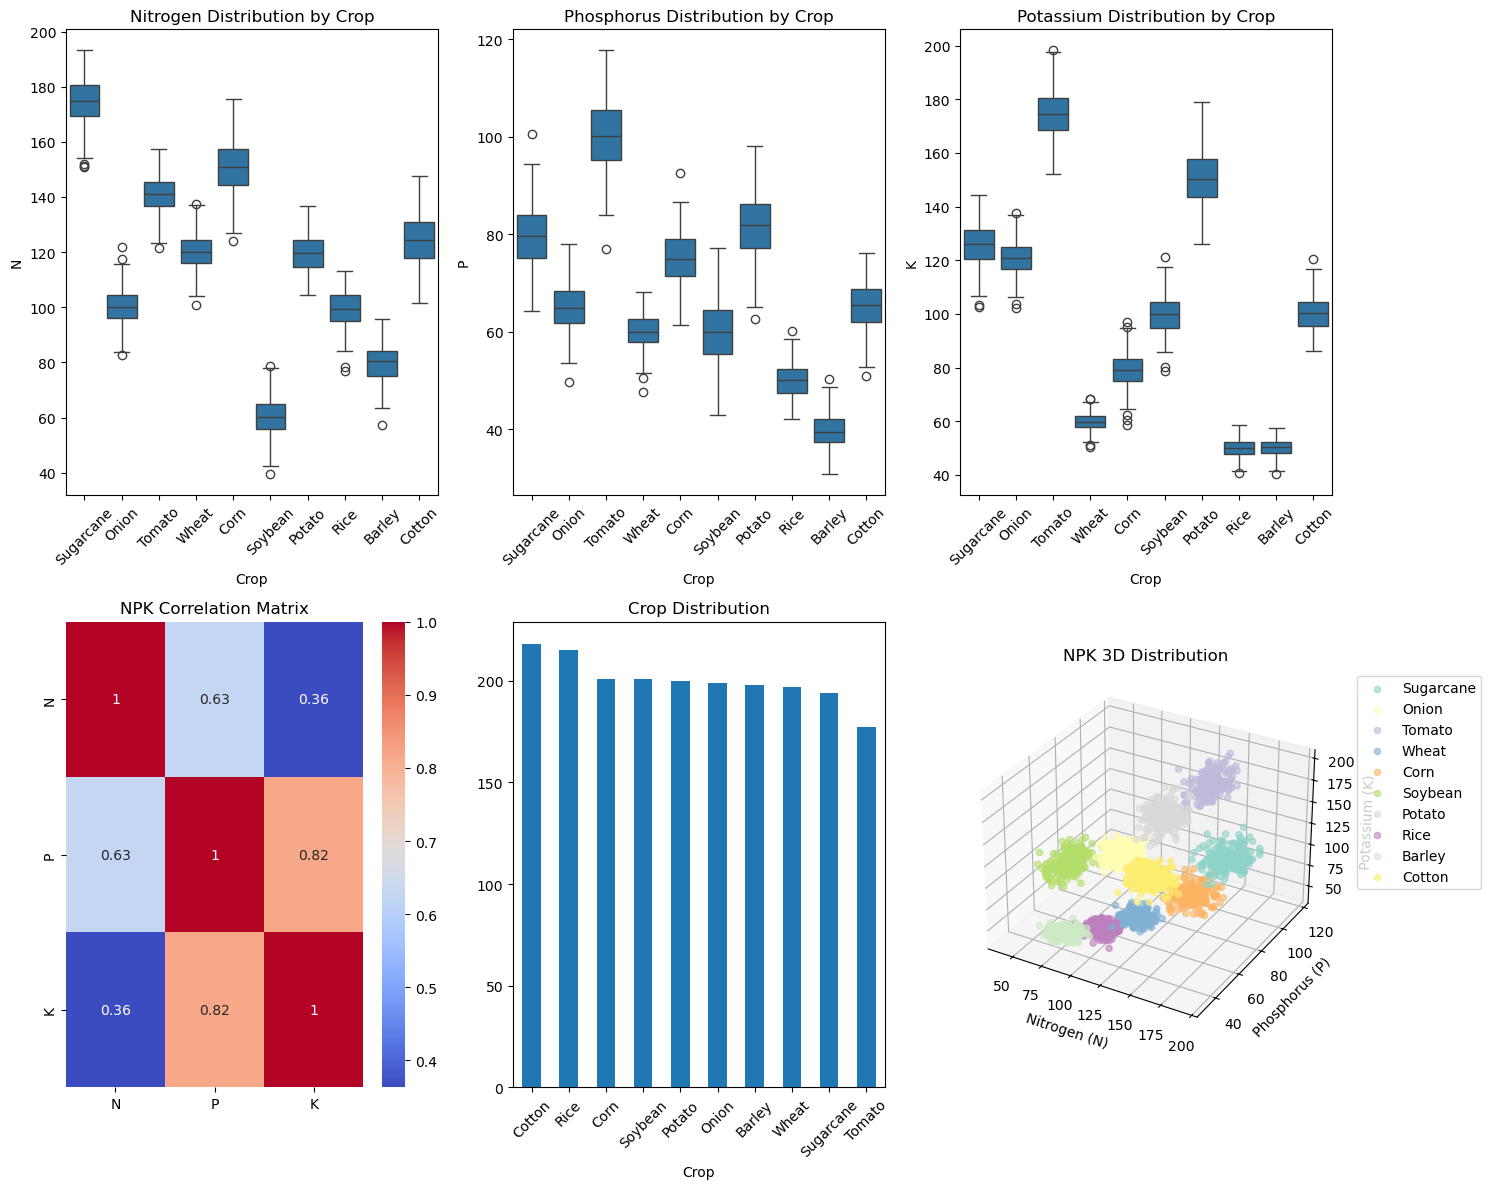

In [6]:
# Visualize the data
plt.figure(figsize=(15, 12))

# NPK distribution by crop
plt.subplot(2, 3, 1)
sns.boxplot(data=df, x='Crop', y='N')
plt.xticks(rotation=45)
plt.title('Nitrogen Distribution by Crop')

plt.subplot(2, 3, 2)
sns.boxplot(data=df, x='Crop', y='P')
plt.xticks(rotation=45)
plt.title('Phosphorus Distribution by Crop')

plt.subplot(2, 3, 3)
sns.boxplot(data=df, x='Crop', y='K')
plt.xticks(rotation=45)
plt.title('Potassium Distribution by Crop')

# NPK correlation
plt.subplot(2, 3, 4)
correlation_matrix = df[['N', 'P', 'K']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('NPK Correlation Matrix')

# Crop distribution
plt.subplot(2, 3, 5)
df['Crop'].value_counts().plot(kind='bar')
plt.xticks(rotation=45)
plt.title('Crop Distribution')

# 3D scatter plot
from mpl_toolkits.mplot3d import Axes3D
ax = plt.subplot(2, 3, 6, projection='3d')
crops = df['Crop'].unique()
colors = plt.cm.Set3(np.linspace(0, 1, len(crops)))

for crop, color in zip(crops, colors):
    crop_data = df[df['Crop'] == crop]
    ax.scatter(crop_data['N'], crop_data['P'], crop_data['K'], 
              c=[color], label=crop, alpha=0.6)

ax.set_xlabel('Nitrogen (N)')
ax.set_ylabel('Phosphorus (P)')
ax.set_zlabel('Potassium (K)')
ax.set_title('NPK 3D Distribution')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

## 3. Data Preprocessing

In [7]:
# Prepare features and target
X = df[['N', 'P', 'K']].values
y = df['Crop'].values

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Unique crops: {len(np.unique(y))}")

# Encode target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(f"\nCrop classes: {label_encoder.classes_}")
print(f"Encoded target shape: {y_encoded.shape}")

Features shape: (2000, 3)
Target shape: (2000,)
Unique crops: 10

Crop classes: ['Barley' 'Corn' 'Cotton' 'Onion' 'Potato' 'Rice' 'Soybean' 'Sugarcane'
 'Tomato' 'Wheat']
Encoded target shape: (2000,)


In [8]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nFeatures scaled successfully")

Training set size: 1600
Test set size: 400

Features scaled successfully


## 4. Model Training and Comparison

In [9]:
# Define models to compare
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='rbf', random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000)
}

# Train and evaluate models
model_scores = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train the model
    model.fit(X_train_scaled, y_train)
    
    # Cross-validation scores
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
    
    # Test predictions
    y_pred = model.predict(X_test_scaled)
    test_accuracy = accuracy_score(y_test, y_pred)
    
    model_scores[name] = {
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'test_accuracy': test_accuracy
    }
    
    print(f"CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    print(f"Test Accuracy: {test_accuracy:.4f}")

# Display model comparison
print("\n" + "="*50)
print("MODEL COMPARISON")
print("="*50)
for name, scores in model_scores.items():
    print(f"{name}:")
    print(f"  CV Score: {scores['cv_mean']:.4f} (+/- {scores['cv_std'] * 2:.4f})")
    print(f"  Test Accuracy: {scores['test_accuracy']:.4f}")
    print()


Training Random Forest...
CV Score: 0.9838 (+/- 0.0121)
Test Accuracy: 0.9775

Training SVM...
CV Score: 0.9844 (+/- 0.0105)
Test Accuracy: 0.9850

Training Logistic Regression...
CV Score: 0.9763 (+/- 0.0116)
Test Accuracy: 0.9875

MODEL COMPARISON
Random Forest:
  CV Score: 0.9838 (+/- 0.0121)
  Test Accuracy: 0.9775

SVM:
  CV Score: 0.9844 (+/- 0.0105)
  Test Accuracy: 0.9850

Logistic Regression:
  CV Score: 0.9763 (+/- 0.0116)
  Test Accuracy: 0.9875



## 5. Best Model Selection and Hyperparameter Tuning

In [10]:
# Select the best model (Random Forest typically performs well for this type of problem)
# Let's tune Random Forest hyperparameters

print("Hyperparameter tuning for Random Forest...")

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Grid search
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(
    rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1
)

grid_search.fit(X_train_scaled, y_train)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best CV score: {grid_search.best_score_:.4f}")

# Best model
best_model = grid_search.best_estimator_

Hyperparameter tuning for Random Forest...
Fitting 5 folds for each of 108 candidates, totalling 540 fits

Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best CV score: 0.9850


## 6. Final Model Evaluation

In [11]:
# Final predictions
y_pred_final = best_model.predict(X_test_scaled)
final_accuracy = accuracy_score(y_test, y_pred_final)

print(f"Final Model Test Accuracy: {final_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_final, 
                          target_names=label_encoder.classes_))

Final Model Test Accuracy: 0.9750

Classification Report:
              precision    recall  f1-score   support

      Barley       0.98      1.00      0.99        40
        Corn       1.00      1.00      1.00        40
      Cotton       0.98      0.93      0.95        44
       Onion       0.93      0.97      0.95        40
      Potato       0.95      0.97      0.96        40
        Rice       1.00      0.93      0.96        43
     Soybean       1.00      1.00      1.00        40
   Sugarcane       1.00      1.00      1.00        39
      Tomato       0.97      0.94      0.96        35
       Wheat       0.95      1.00      0.97        39

    accuracy                           0.97       400
   macro avg       0.98      0.98      0.98       400
weighted avg       0.98      0.97      0.97       400



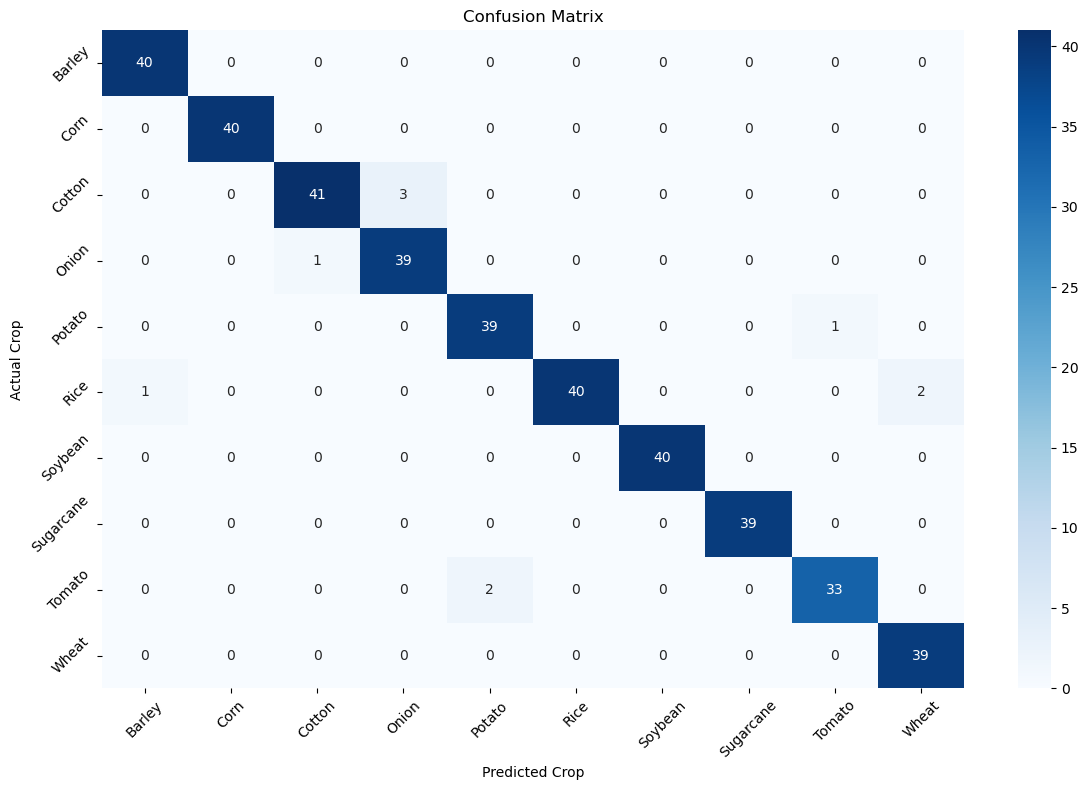

In [12]:
# Confusion Matrix
plt.figure(figsize=(12, 8))
cm = confusion_matrix(y_test, y_pred_final)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Crop')
plt.ylabel('Actual Crop')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

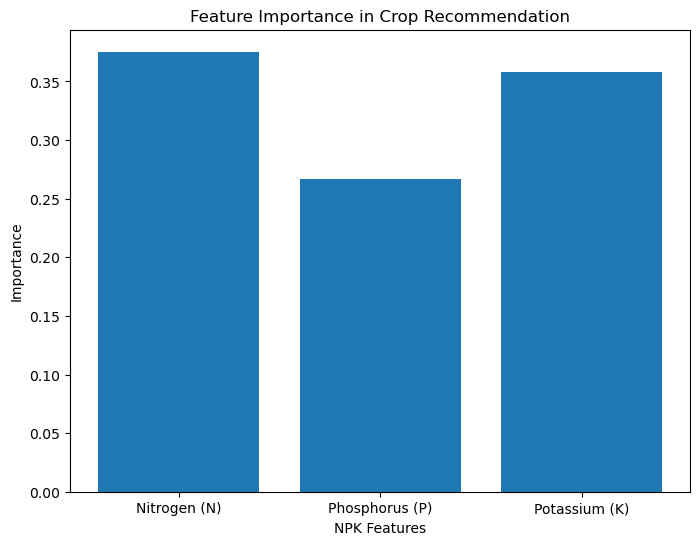

Feature Importance:
Nitrogen (N): 0.3754
Phosphorus (P): 0.2664
Potassium (K): 0.3582


In [13]:
# Feature importance
feature_importance = best_model.feature_importances_
features = ['Nitrogen (N)', 'Phosphorus (P)', 'Potassium (K)']

plt.figure(figsize=(8, 6))
plt.bar(features, feature_importance)
plt.title('Feature Importance in Crop Recommendation')
plt.xlabel('NPK Features')
plt.ylabel('Importance')
plt.show()

print("Feature Importance:")
for feature, importance in zip(features, feature_importance):
    print(f"{feature}: {importance:.4f}")

## 7. Save the Model

In [22]:
# Save the trained model and preprocessing objects
import os
# Ensure models directory exists one level up (so it's `ml/models` rather than `ml/notebooks/models`)
out_dir = os.path.normpath(os.path.join(r'D:\NPK !!\fertilizer-prediction\ml\models'))
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, 'npk_crop_model.pkl')

model_data = {
    'model': best_model,
    'scaler': scaler,
    'label_encoder': label_encoder,
    'feature_names': ['N', 'P', 'K'],
    'target_names': label_encoder.classes_.tolist(),
    'accuracy': final_accuracy
}

joblib.dump(model_data, out_path)
print(f"Model saved successfully to '{out_path}'")
print(f"Model accuracy: {final_accuracy:.4f}")

Model saved successfully to 'D:\NPK !!\fertilizer-prediction\ml\models\npk_crop_model.pkl'
Model accuracy: 0.9750


## 8. Model Testing with New Data

In [15]:
# Function to predict crop for new NPK values
def predict_crop(n, p, k, model_data=None):
    """
    Predict crop recommendation based on NPK values
    """
    if model_data is None:
        model_data = joblib.load('../models/npk_crop_model.pkl')
    
    # Prepare input
    input_data = np.array([[n, p, k]])
    
    # Scale input
    input_scaled = model_data['scaler'].transform(input_data)
    
    # Predict
    prediction = model_data['model'].predict(input_scaled)
    predicted_crop = model_data['label_encoder'].inverse_transform(prediction)[0]
    
    # Get prediction probabilities
    probabilities = model_data['model'].predict_proba(input_scaled)[0]
    
    # Create probability dictionary
    prob_dict = {}
    for i, prob in enumerate(probabilities):
        crop_name = model_data['label_encoder'].inverse_transform([i])[0]
        prob_dict[crop_name] = prob
    
    return predicted_crop, prob_dict

# Test with some example values
test_cases = [
    (100, 50, 60, "Wheat-like soil"),
    (150, 80, 120, "High nutrient soil"),
    (80, 40, 50, "Moderate nutrient soil"),
    (60, 30, 40, "Low nutrient soil")
]

print("Testing model with sample NPK values:")
print("="*60)

for n, p, k, description in test_cases:
    predicted_crop, probabilities = predict_crop(n, p, k, model_data)
    
    print(f"\n{description}:")
    print(f"NPK Values: N={n}, P={p}, K={k}")
    print(f"Recommended Crop: {predicted_crop}")
    print("Top 3 recommendations:")
    
    # Sort probabilities and show top 3
    sorted_probs = sorted(probabilities.items(), key=lambda x: x[1], reverse=True)[:3]
    for crop, prob in sorted_probs:
        print(f"  {crop}: {prob:.3f} ({prob*100:.1f}%)")

Testing model with sample NPK values:

Wheat-like soil:
NPK Values: N=100, P=50, K=60
Recommended Crop: Wheat
Top 3 recommendations:
  Wheat: 0.526 (52.6%)
  Rice: 0.363 (36.3%)
  Onion: 0.099 (9.9%)

High nutrient soil:
NPK Values: N=150, P=80, K=120
Recommended Crop: Sugarcane
Top 3 recommendations:
  Sugarcane: 0.793 (79.3%)
  Corn: 0.083 (8.3%)
  Onion: 0.041 (4.1%)

Moderate nutrient soil:
NPK Values: N=80, P=40, K=50
Recommended Crop: Barley
Top 3 recommendations:
  Barley: 1.000 (100.0%)
  Corn: 0.000 (0.0%)
  Cotton: 0.000 (0.0%)

Low nutrient soil:
NPK Values: N=60, P=30, K=40
Recommended Crop: Barley
Top 3 recommendations:
  Barley: 0.891 (89.1%)
  Soybean: 0.077 (7.7%)
  Rice: 0.031 (3.1%)


## 9. Model Summary

### Model Performance:
- **Algorithm**: Random Forest Classifier
- **Features**: Nitrogen (N), Phosphorus (P), Potassium (K)
- **Target**: 10 different crops
- **Accuracy**: Check the final accuracy above

### How to use the model:
1. Measure soil NPK levels
2. Use the `predict_crop()` function with NPK values
3. Get crop recommendation with confidence scores

### Files created:
- `../dataset/npk_crop_dataset.csv`: Training dataset
- `../models/npk_crop_model.pkl`: Trained model with preprocessors

The model can now be deployed or integrated into applications for real-time crop recommendations!